###### Welcome to my Etsy Analysis. 

For this analysis I have examined this data set: https://www.kaggle.com/datasets/polartech/1m-etsy-shops-sales-data

In it is the top 20,000 Etsy shops (by sales) as of April 3rd, 2022.

Given this, there are some limitations, as newer shops with lower total sales will not be included. Additionally, precise information about each shop (information on their actual listings for example) are not included, and therefore manual analysis may be needed to determine what sets apart the top performing shops. 

Additionally, shops that rely on higher priced listings with lower sales quantity will likely be missing from the dataset.

###### What you will find in this analysis:

- The most popular terms in shop headlines with the ability to search for specifc keywords.
- Which headline keywords are most correlated with average annual sales (with the ability to search for specific keywords)
- Determine correlation between two variables, and create a scatter plot with essential shop data for further analysis.
- Lastly, what effect free shipping has on sales.

Please note that I have examined:

- correlation between shop age and total sales
- correlation between shop age and average annual sales
- correlation between listing count and average annual sales for both physical and digital product shops. 

The functions can be tweaked to dig further into the data as needed.



###### Based on the findings in this analysis, a few things become clear:

- Having more listings does seem to be correlated with having greater overall sales to some minor extent. 
- Free shipping may have some positive effect on sales but does not appear statistically significant.
- Shop age does not seem to be correlated with sales success. 

Average annual sales appears negative for older shops, but this is likely due to Etsy's growth as a platform over recent years.

In [26]:
!pip install mplcursors
%matplotlib notebook
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from scipy.stats import pearsonr
from scipy.stats import iqr
from scipy.stats import pearsonr, ttest_ind
import mplcursors

# Ensure that the nltk stopword corpus is downloaded
nltk.download('punkt')
nltk.download('stopwords')


#read in the CSV
etsy = pd.read_csv("Etsy April 2022.csv")


#cleaning the dataframe
etsy['shop_create_date'] = etsy.shop_create_date.apply(
lambda x:datetime.fromtimestamp(x).date())

etsy['shop_update_date'] = etsy.shop_update_date.apply(
lambda x:datetime.fromtimestamp(x).date())


# Drop rows with missing values in 'has_free_shipping' and 'has_min_free_shipping' columns (1446 entries of 10,000)
etsy = etsy.dropna(subset=['has_free_shipping', 'has_min_free_shipping'])




#drop any unnecessary columns for our analysis
etsy.drop('RunDate', axis=1, inplace=True)
etsy.drop('primary_language_id', axis=1, inplace=True)
etsy.drop('has_currency_code', axis=1, inplace=True)
etsy.drop('accepts_direct_checkout', axis=1, inplace=True)
etsy.drop('accepts_paypal', axis=1, inplace=True)
etsy.drop('geoname_id', axis=1, inplace=True)
etsy.drop('ships_to_country_ids', axis=1, inplace=True)
etsy.drop('ships_to_regions', axis=1, inplace=True)
etsy.drop('country_code', axis=1, inplace=True)
etsy.drop('display_name', axis=1, inplace=True)
etsy.drop('is_eligible_free_shipping', axis=1, inplace=True)
etsy.drop('region', axis=1, inplace=True)
etsy.drop('shop_id', axis=1, inplace=True)
etsy.drop('city', axis=1, inplace=True)
etsy.drop('location', axis=1, inplace=True)
etsy.drop('status', axis=1, inplace=True)


# Convert the 'shop_create_date' to datetime if it's not already
etsy['shop_create_date'] = pd.to_datetime(etsy['shop_create_date'])

# Calculate the shop age in years
etsy['shop_age'] = (datetime.now() - etsy['shop_create_date']).dt.days / 365

# Calculate annual sales to get a more fair indication of performance (as older shops should inherently have greater total sales)
etsy['annual_sales'] = etsy['sold_count'] / etsy['shop_age']

# Remove shops with age 0 to avoid division by zero errors
etsy = etsy[etsy['shop_age'] != 0]


# Remove NaNs from 'headline'
etsy['headline'] = etsy['headline'].fillna('')

print("Total shops in Dataset after dropping rows:" + str(etsy.url.count()))

# Shops with more digital listings than physical listings
etsy_digital = etsy[etsy['digital_listing_count'] > (etsy['active_listing_count'] - etsy['digital_listing_count'])]
print("Digital shops in Dataset:" + str(etsy_digital.url.count()))

# Shops with only physical listings
etsy_physical = etsy[etsy['digital_listing_count'] == 0]
print("Physical shops in Dataset:" + str(etsy_physical.url.count()))


Total shops in Dataset after dropping rows:8554
Digital shops in Dataset:1477
Physical shops in Dataset:6256


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Helper functions to be called on later

def interpret_correlation(corr):
    abs_corr = abs(corr)
    if abs_corr < 0.1:
        print('Negligible correlation\n')
    elif abs_corr < 0.3:
        if corr > 0:
            print('Small positive correlation\n')
        else:
            print('Small negative correlation\n')
    elif abs_corr < 0.5:
        if corr > 0:
            print('Medium positive correlation\n')
        else:
            print('Medium negative correlation\n')
    else:
        if corr > 0:
            print('Large positive correlation\n')
        else:
            print('Large negative correlation\n')
        
def interpret_t_test(t_stat, p_val):
    print(f'Absolute T-stat: {abs(t_stat)}')
    if abs(t_stat) < 1.96:
        print('The T-statistic is less than 1.96, meaning we fail to reject the null hypothesis.\n')
    else:
        print('The T-statistic is greater than 1.96, meaning we reject the null hypothesis.\n\n')
    
    print(f'p-value: {p_val}')
    if p_val < 0.05:
        print('The p-value is less than 0.05, meaning the results are statistically significant.\n')
    else:
        print('The p-value is greater than 0.05, meaning the results are not statistically significant.\n\n')
        
def remove_outliers(df, column,iqrval):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = iqr(df[column])

    # Only keep rows in the dataframe that are within the IQR
    df = df[(df[column] >= (Q1 - iqrval*IQR)) & (df[column] <= (Q3 + iqrval*IQR))]

    return df

In [36]:
#Start by examining the most common terms in the dataset. We can search by up to two keywords to narrow down results.
def most_common_terms (dataframe, keyword1=None, keyword2=None):
    
    if keyword1 and keyword2:
        custom_df = dataframe[dataframe['headline'].str.contains(keyword1, na=False, case=False) & 
                         dataframe['headline'].str.contains(keyword2, na=False, case=False)].copy()
    elif keyword1:
        custom_df = dataframe[dataframe['headline'].str.contains(keyword1, na=False, case=False)].copy()
    else:
        custom_df = dataframe.copy()

    # Lowercase and tokenize words in 'headline'
    custom_df['headline_words'] = custom_df['headline'].apply(lambda x: word_tokenize(x.lower()))

    # Define a set of stop words and punctuation to remove
    stop_words = set(stopwords.words('english')).union(set(string.punctuation))

    # Remove stop words and punctuation
    custom_df['headline_words'] = custom_df['headline_words'].apply(lambda x: [word for word in x if word not in stop_words])

    # Flatten list of words in 'headline_words'
    all_words = [word for words in custom_df['headline_words'] for word in words]

    # Calculate frequency distribution
    freq_dist = nltk.FreqDist(all_words)

    # Print 20 most common words, their counts, and top 3 shops for each
    for word, frequency in freq_dist.most_common(20):
        print(f'{word}: {frequency}')
        
        # Filter shops with the word in their headlines
        shops_with_word = custom_df[custom_df['headline'].str.contains(word, case=False)]
        
        # Get top 3 shops based on 'sold_count'
        top_shops = shops_with_word.sort_values('annual_sales', ascending=False)[:3]
        
        for _, shop in top_shops.iterrows():
            print(f"Shop URL: {shop['url']}, annual sales: {shop['annual_sales']}")
        print()
        
most_common_terms(etsy_digital,"art")


art: 108
Shop URL: https://www.etsy.com/shop/HeatherRobertsArt, annual sales: 146887.35418427727
Shop URL: https://www.etsy.com/shop/DigitalCurio, annual sales: 63033.22758415252
Shop URL: https://www.etsy.com/shop/ExpertOutfit, annual sales: 52424.97441951987

digital: 91
Shop URL: https://www.etsy.com/shop/Prettygrafikdesign, annual sales: 45896.993414387034
Shop URL: https://www.etsy.com/shop/FeathersofStyle, annual sales: 24271.77507447865
Shop URL: https://www.etsy.com/shop/JaneJoArt, annual sales: 23544.077460106382

party: 83
Shop URL: https://www.etsy.com/shop/DIYPaperBoutique, annual sales: 26088.200636942674
Shop URL: https://www.etsy.com/shop/DamlaDigital, annual sales: 16954.520084566597
Shop URL: https://www.etsy.com/shop/LittlePrintsParties, annual sales: 16473.692803437163

printable: 67
Shop URL: https://www.etsy.com/shop/MyPorchPrints, annual sales: 51710.65032414911
Shop URL: https://www.etsy.com/shop/NorthPrints, annual sales: 45300.712900096994
Shop URL: https://www

In [42]:
#Examining the top shops (when correlated with sales) for up to two given keywords

def headline_terms (dataframe, keyword1=None, keyword2=None, min_samples=20):
    
    if keyword1 and keyword2:
        custom_df = dataframe[dataframe['headline'].str.contains(keyword1, na=False, case=False) & 
                         dataframe['headline'].str.contains(keyword2, na=False, case=False)].copy()
    elif keyword1:
        custom_df = dataframe[dataframe['headline'].str.contains(keyword1, na=False, case=False)].copy()
    else:
        custom_df = dataframe.copy()

    # Lowercase and tokenize words in 'headline'
    custom_df['headline_words'] = custom_df['headline'].apply(lambda x: word_tokenize(x.lower()))

    # Define a set of stop words and punctuation to remove
    stop_words = set(stopwords.words('english')).union(set(string.punctuation))

    # Remove stop words and punctuation
    custom_df['headline_words'] = custom_df['headline_words'].apply(lambda x: [word for word in x if word not in stop_words])

    # Flatten list of words in 'headline_words'
    all_words = [word for words in custom_df['headline_words'] for word in words]

    # Calculate frequency distribution
    freq_dist = nltk.FreqDist(all_words)

    # Get common words
    common_words = [word for word, _ in freq_dist.most_common(50)]
    
    # Add boolean columns for common words
    for word in common_words:
        custom_df[word] = custom_df['headline'].apply(lambda x: word in str(x).lower())

    # Compute and store correlations
    correlations = {}
    for word in common_words:
        # Add check for variation in column
        if custom_df[word].nunique() < 2:
            continue
        correlations[word] = pearsonr(custom_df[word], custom_df['annual_sales'])[0]

    # Print correlations
    sorted_correlations = sorted(correlations.items(), key=lambda item: item[1], reverse=True)
    top_correlated_words = []
    for word, corr in sorted_correlations:
        top_shops = custom_df[custom_df[word] == True].sort_values(by='annual_sales', ascending=False)[['url', 'annual_sales']]
        if len(top_shops) >= min_samples:
            top_correlated_words.append((word, corr))
        if len(top_correlated_words) == 10:
            break
    
    # Print top 3 shops and total matching shops for each top 10 correlated words
    for word, corr in top_correlated_words:
        top_shops = custom_df[custom_df[word] == True].sort_values(by='annual_sales', ascending=False)[['url', 'annual_sales']]
        print(f'\n\nCorrelation of "{word}" with annual sales: {corr}')
        print(f'Total matching shops for "{word}": {len(top_shops)}\n')
        for idx, row in top_shops.head(3).iterrows():
            print(f'Shop URL: {row["url"]}, annual sales: {row["annual_sales"]}')

headline_terms(etsy_digital,"svg")




Correlation of "art" with annual sales: 0.13955971778118703
Total matching shops for "art": 37

Shop URL: https://www.etsy.com/shop/HeatherRobertsArt, annual sales: 146887.35418427727
Shop URL: https://www.etsy.com/shop/ExpertOutfit, annual sales: 52424.97441951987
Shop URL: https://www.etsy.com/shop/RuyaTreasures, annual sales: 45243.656716417914


Correlation of "clipart" with annual sales: 0.1275175218871934
Total matching shops for "clipart": 25

Shop URL: https://www.etsy.com/shop/HeatherRobertsArt, annual sales: 146887.35418427727
Shop URL: https://www.etsy.com/shop/RuyaTreasures, annual sales: 45243.656716417914
Shop URL: https://www.etsy.com/shop/JaneJoArt, annual sales: 23544.077460106382


Correlation of "clip" with annual sales: 0.10854279738882512
Total matching shops for "clip": 32

Shop URL: https://www.etsy.com/shop/HeatherRobertsArt, annual sales: 146887.35418427727
Shop URL: https://www.etsy.com/shop/RuyaTreasures, annual sales: 45243.656716417914
Shop URL: https://w

In [5]:
# Create a function that analyzes the correlation between two variables. 

def correlation(df, x_column='active_listing_count', y_column='annual_sales', iqrval=5):
    
    # Remove outliers
    df = remove_outliers(df, x_column, iqrval)

    # Calculate the correlation
    correlation, _ = pearsonr(df[x_column], df[y_column])
    
    # Print the correlation
    print(f'Correlation between {x_column} and {y_column}: {correlation}')
    
    # Interpret the correlation strength using the provided function
    interpret_correlation(correlation)
    
    # Create a scatterplot
    fig, ax = plt.subplots(figsize=(10, 6))
    scatter = ax.scatter(df[x_column], df[y_column])

    # Configure mplcursors
    cursor = mplcursors.cursor(scatter, hover=False)

    # Make it so we can see essential shop data when we click on a point
    @cursor.connect("add")
    def on_add(sel):
        x, y = sel.target
        index = sel.target.index
        sel.annotation.set_text(f'Shop Name: {df.iloc[index]["shop_name"]}\n'
                                f'URL: {df.iloc[index]["url"]}\n'
                                f'Create Date: {df.iloc[index]["shop_create_date"]}\n'
                                f'Annual Sales: {df.iloc[index]["annual_sales"]}')
        print(f'URL: {df.iloc[index]["url"]}')  # print URL to console
        sel.annotation.set_bbox(None)

    plt.title(f'Scatterplot of {x_column} vs. {y_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.show()




Etsy Physical Shops - Listing count vs Average Annual Sales

Correlation between active_listing_count and annual_sales: 0.11720684002025382
Small positive correlation



<IPython.core.display.Javascript object>


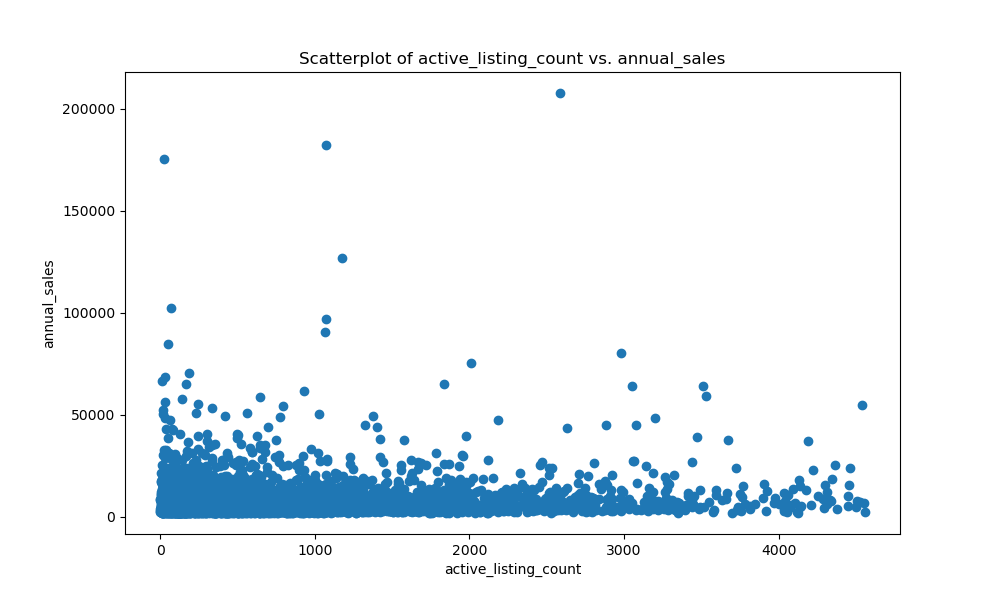

In [6]:
#How correlated is the listing count with Physical listing shops??
print('Etsy Physical Shops - Listing count vs Average Annual Sales\n')
correlation(etsy_physical)

Etsy Digital Shops - Listing count vs Average Annual Sales

Correlation between active_listing_count and annual_sales: 0.2549761144423587
Small positive correlation



<IPython.core.display.Javascript object>


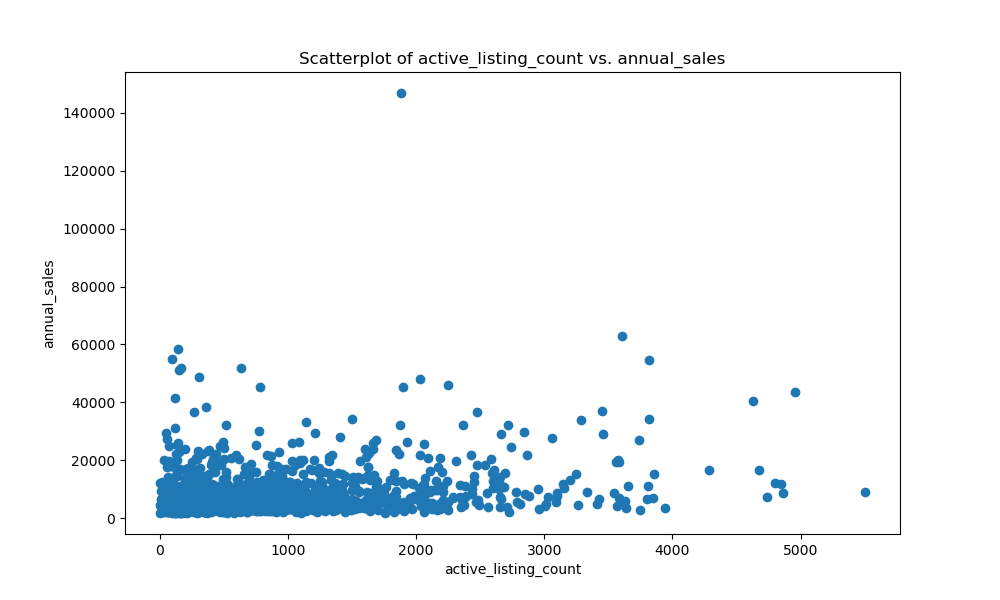

In [7]:
#How correlated are listing count with digital listing shops?
print('Etsy Digital Shops - Listing count vs Average Annual Sales\n')
correlation(etsy_digital)

Etsy Shop Age vs Average Annual Sales

Correlation between shop_age and annual_sales: -0.31572481613148834
Medium negative correlation



<IPython.core.display.Javascript object>


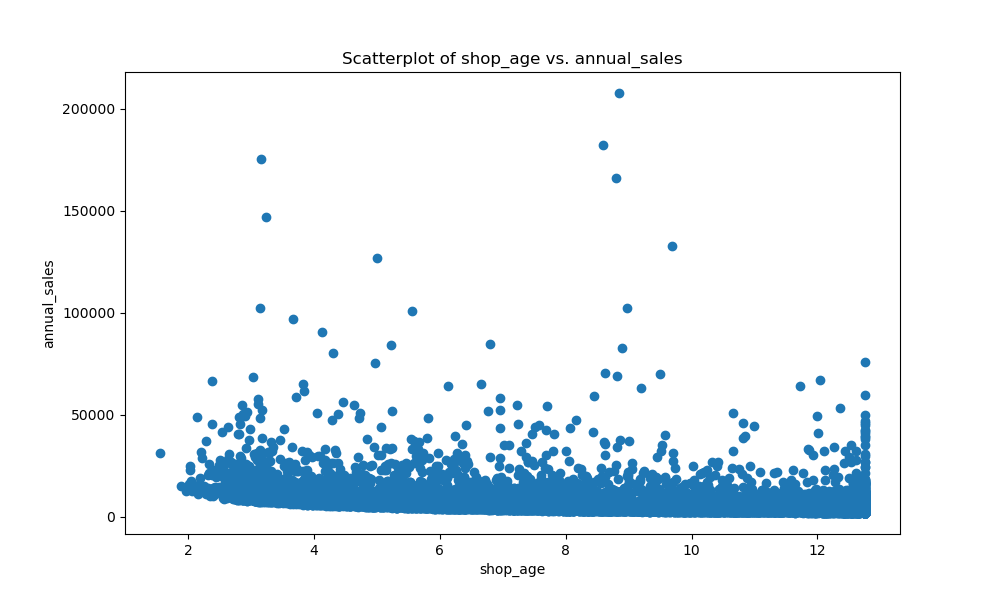

In [8]:
#How correlated are shop age and average annual sales?
print('Etsy Shop Age vs Average Annual Sales\n')
correlation(etsy,'shop_age','annual_sales')

Etsy Shop Age vs Total Sales

Correlation between shop_age and annual_sales: -0.31572481613148834
Medium negative correlation



<IPython.core.display.Javascript object>


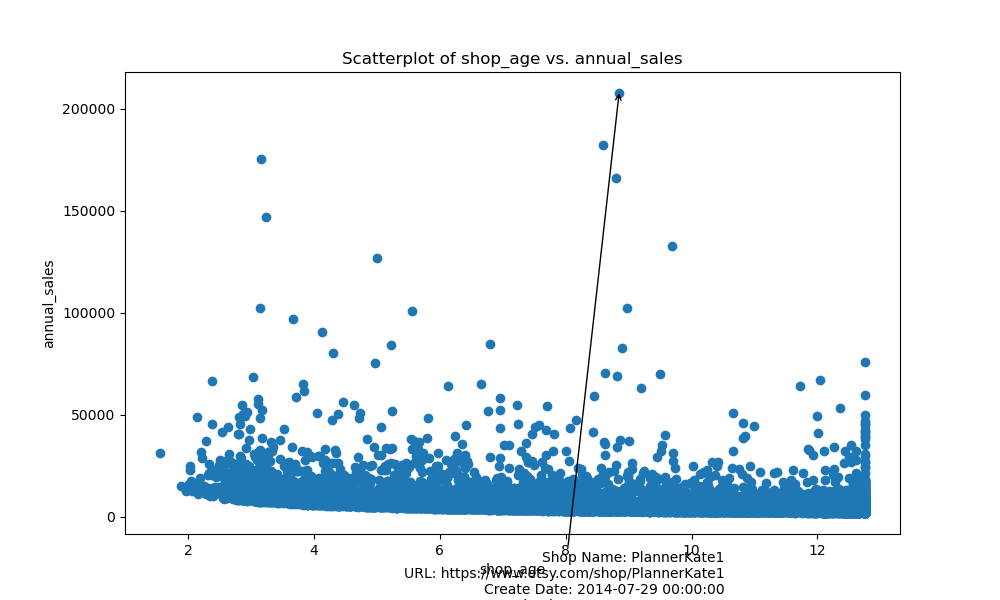

In [9]:
#How correlated are shop age and total sales?
print('Etsy Shop Age vs Total Sales\n')
correlation(etsy,'shop_age','annual_sales')

Physical Listing Shops: 


Correlation between having free shipping and sales: 0.033582301763000436
Negligible correlation

T-test results for free shipping: T-stat = 2.486508027761625, p-value = 0.012964502014275956

Absolute T-stat: 2.486508027761625
The T-statistic is greater than 1.96, meaning we reject the null hypothesis.


p-value: 0.012964502014275956
The p-value is less than 0.05, meaning the results are statistically significant.



<IPython.core.display.Javascript object>


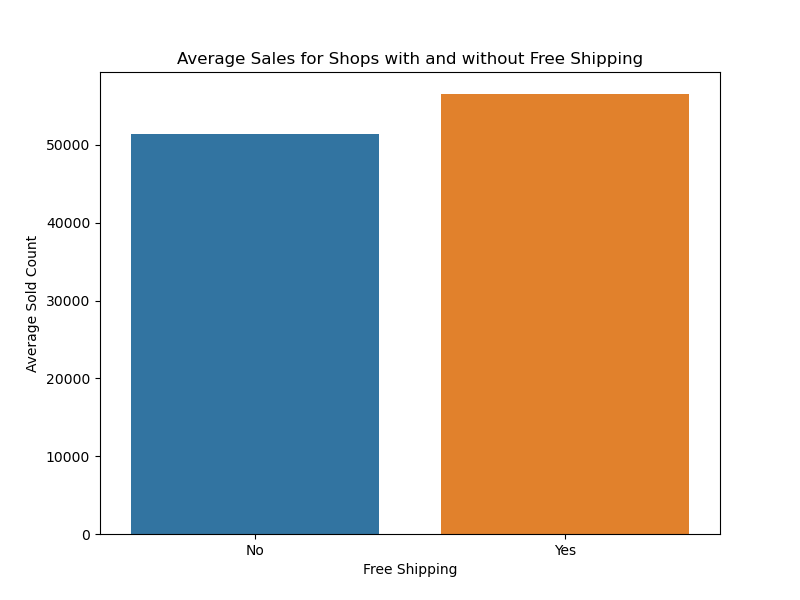

Correlation between having minimum free shipping and sales: 0.06469582583720565
Negligible correlation

T-test results for minimum free shipping: T-stat = 5.110453971325717, p-value = 3.313873605584062e-07

Absolute T-stat: 5.110453971325717
The T-statistic is greater than 1.96, meaning we reject the null hypothesis.


p-value: 3.313873605584062e-07
The p-value is less than 0.05, meaning the results are statistically significant.



<IPython.core.display.Javascript object>


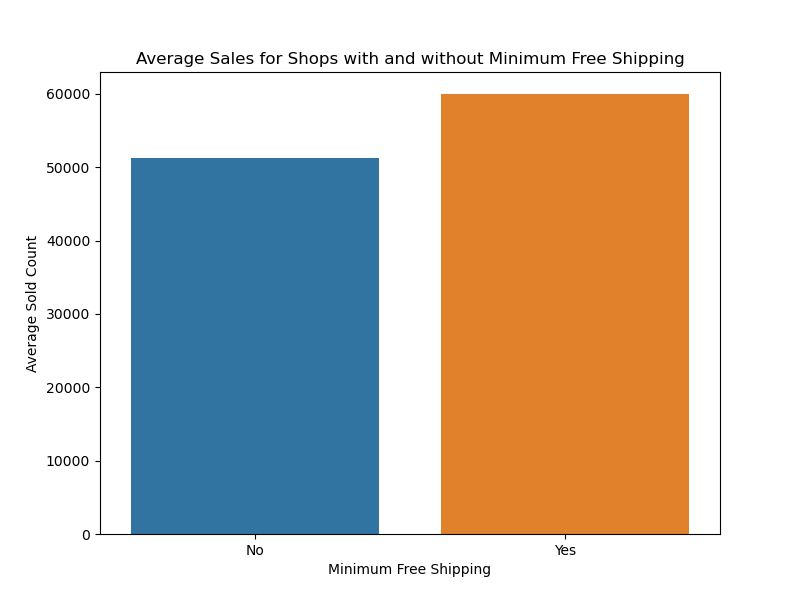

In [13]:
#Lastly, How correlated is having free shipping with sales count? We can ignore digital shops as they inherently have free shipping.

def shipping_correlation (dataframe):
    # Group the data by 'has_free_shipping' and calculate the mean of 'sold_count'
    free_shipping_sales = dataframe[dataframe['has_free_shipping'] == True]['sold_count']
    no_free_shipping_sales = dataframe[dataframe['has_free_shipping'] == False]['sold_count']

    # Calculate and print correlation for free shipping
    corr, _ = pearsonr(dataframe['has_free_shipping'], dataframe['sold_count'])
    print(f'Correlation between having free shipping and sales: {corr}')
    interpret_correlation(corr)

    # Perform t-test for free shipping
    t_stat, p_val = ttest_ind(free_shipping_sales, no_free_shipping_sales, equal_var=False)
    print(f'T-test results for free shipping: T-stat = {t_stat}, p-value = {p_val}\n')
    interpret_t_test(t_stat, p_val)
    
    # Plotting the results for Free Shipping
    plt.figure(figsize=(8, 6))
    sns.barplot(x=['No', 'Yes'], y=[no_free_shipping_sales.mean(), free_shipping_sales.mean()])
    plt.title('Average Sales for Shops with and without Free Shipping')
    plt.xlabel('Free Shipping')
    plt.ylabel('Average Sold Count')
    plt.show()

    # Group the data by 'has_min_free_shipping' and calculate the mean of 'sold_count'
    min_free_shipping_sales = dataframe[dataframe['has_min_free_shipping'] == True]['sold_count']
    no_min_free_shipping_sales = dataframe[dataframe['has_min_free_shipping'] == False]['sold_count']

    # Calculate and print correlation for minimum free shipping
    corr, _ = pearsonr(dataframe['has_min_free_shipping'], dataframe['sold_count'])
    print(f'Correlation between having minimum free shipping and sales: {corr}')
    interpret_correlation(corr)

    # Perform t-test for minimum free shipping
    t_stat, p_val = ttest_ind(min_free_shipping_sales, no_min_free_shipping_sales, equal_var=False)
    print(f'T-test results for minimum free shipping: T-stat = {t_stat}, p-value = {p_val}\n')
    interpret_t_test(t_stat, p_val)
    
    # Plotting the results for Minimum Free Shipping
    plt.figure(figsize=(8, 6))
    sns.barplot(x=['No', 'Yes'], y=[no_min_free_shipping_sales.mean(), min_free_shipping_sales.mean()])
    plt.title('Average Sales for Shops with and without Minimum Free Shipping')
    plt.xlabel('Minimum Free Shipping')
    plt.ylabel('Average Sold Count')
    plt.show()

print("Physical Listing Shops: \n\n")   
shipping_correlation(etsy_physical)
